# Multireference

In [52]:
import numpy as np
import re
from itertools import islice
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as const

import os
import sys
from pathlib import Path
from matplotlib import style
from lmfit import Parameters, fit_report, minimize
from lmfit.models import LinearModel
style.use('default')                # needed for vscode dark theme to see the axis

In [53]:
save_as_pgf = 0
save_as_pdf = 1

if save_as_pgf == 1:
    #mpl.use("pgf")                        
    mpl.rc('text', usetex=True)           # needed for latex
    mpl.rc('pgf', texsystem='pdflatex')   # change this if using xetex or luatex
    mpl.rc('pgf', rcfonts=False)          # don't setup fonts from rc parameters
    mpl.rc('pgf', preamble="\n".join([    # load additional packages
           r"\usepackage[utf8x]{inputenc}",
           r"\usepackage[T1]{fontenc}",
           r"\usepackage{amsmath,amsfonts,amsthm,amssymb,amstext}"]))
    mpl.rc('font', size=8)                # default font size
    mpl.rc('font', family='serif')          # use serif fonts
    #mpl.rc('font', family='sans-serif')   # use sans-serif fonts
    mpl.rc('font', serif='Latin Modern')  # use latex default serif font
    mpl.rc('axes', titlesize=10)           # fontsize of the axes title
    mpl.rc('axes', titlepad=2)            # pad between axis and title
    mpl.rc('axes', labelsize=10)           # fontsize of the x and y labels
    mpl.rc('xtick', labelsize=8)          # fontsize of the tick labels
    mpl.rc('ytick', labelsize=8)          # fontsize of the tick labels
    mpl.rc('legend', fontsize=8)          # legend fontsize
    mpl.rc('figure', titlesize=10)         # fontsize of the figure title
    mpl.rc('lines', markersize=2)         # default line markersize
    mpl.rc('lines', marker="")            # default line marker
    mpl.rc('grid', alpha=0.4)             # transparency of the grid
    mpl.rc('grid', color="gray")          # color of the grid
    mpl.rc('grid', linewidth=0.5)         # linewidth of the grid
    mpl.rcParams['figure.constrained_layout.use'] = True # use constrained_layout
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b", "g", "orange", "purple"]) #matplotlib colororder-default ändern
    lw = 1.0                              # linewidth of the lines

    # width and height of tex document in inches
    # For Katrins Bachelor thesis
    # in Latex:
    # \usepackage{layouts}
    # textwidth in inches: \printinunitsof{in}\prntlen{\textwidth}
    
    fig_width = 6.202
    fig_height = fig_width * 0.6
    
elif save_as_pdf == 1:
    normal = 9                              # fontsize of the text
    mpl.rc('font', size=normal+2)             # default font size
    mpl.rc('font', family='serif')          # use serif fonts
    mpl.rc('axes', titlesize=normal)        # fontsize of the axes title
    mpl.rc('axes', titlepad=5)              # pad between axis and title
    mpl.rc('axes', labelpad=7)              # pad between axis and label
    mpl.rc('axes', labelsize=normal+2)      # fontsize of the x and y labels
    mpl.rc('xtick', labelsize=normal)       # fontsize of the tick labels
    mpl.rc('ytick', labelsize=normal)       # fontsize of the tick labels
    mpl.rc('legend', fontsize=normal)       # legend fontsize
    mpl.rc('figure', titlesize=normal+4)    # fontsize of the figure title
    mpl.rc('lines', markersize=12)          # default line markersize
    mpl.rc('lines', marker="")              # default line marker
    mpl.rc('grid', alpha=0.4)               # transparency of the grid              
    mpl.rc('grid', color="gray")            # color of the grid
    mpl.rc('grid', linewidth=0.5)           # linewidth of the grid
    mpl.rcParams["xtick.major.size"] = 8    # major tick size in points
    mpl.rcParams["ytick.major.size"] = 8    # major tick size in points
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b", "g", "orange", "purple"]) #matplotlib colororder-default ändern
    
    lw = 2
    ms_4 = 4
    ms_8 = 8

    # height and width for nice print in jupyter notebook
    fig_width = 8
    fig_height = 5
    
else:
    mpl.rc('font', size=16)                 # controls default text sizes
    mpl.rc('axes', titlesize=16)            # fontsize of the axes title
    mpl.rc('axes', labelsize=18)            # fontsize of the x and y labels
    mpl.rc('xtick', labelsize=16)           # fontsize of the tick labels
    mpl.rc('ytick', labelsize=16)           # fontsize of the tick labels
    mpl.rc('legend', fontsize=18)           # legend fontsize
    mpl.rc('figure', titlesize=18)          # fontsize of the figure title
    mpl.rc('grid', alpha=0.4)
    mpl.rc('lines', markersize=10)    
    
    

def save_plot_as_pgf(fig, path):
  if save_as_pgf == 1:
    fig.savefig(path, format="pgf")

def save_plot_as_pdf(fig, path):
  if save_as_pdf == 1:
    fig.savefig(path, format="pdf", bbox_inches='tight')


Calculation the potential energy curves for the dissociation of HF with the single-reference methods RHF, UHF, MP2, CCSD(T) and CASSCF, which is a multi-reference method. 

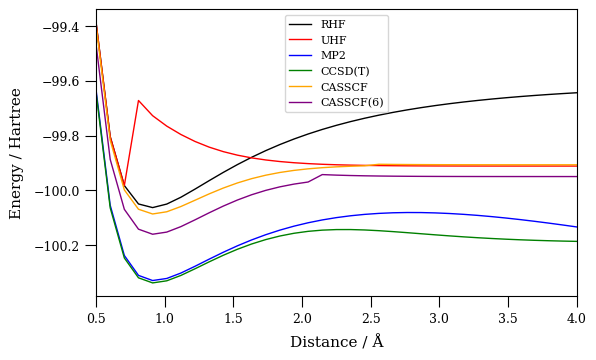

In [54]:
# Load data
RHF = np.loadtxt('rhf/rhf.trjact.dat', usecols=(1), skiprows=1)
UHF = np.loadtxt('uhf/uhf.trjact.dat', usecols=(1), skiprows=1)
CCSD_T = np.loadtxt('CCSD(T)/CCSD_T.trjact.dat', usecols=(1), skiprows=1)
CASSCF = np.loadtxt('CASSCF/CASSCF_2.trjact.dat', usecols=(1), skiprows=1)
CASSCF_6 = np.loadtxt('CASSCF/CASSCF_6.trjact.dat', usecols=(1), skiprows=1)
MP2 = np.loadtxt('MP2/MP2.trjact.dat', usecols=(1), skiprows=1)
x = np.loadtxt('rhf/rhf.trjact.dat', usecols=(0), skiprows=1)

# define figure
fig_width = 6.202
fig_height = fig_width * 0.6
fig = plt.figure(figsize=(fig_width, fig_height))
spec = fig.add_gridspec(ncols=1, nrows=1, height_ratios=[1])

# define subplots
ax1 = fig.add_subplot(spec[0, 0])

# plot data
lw = 1.0 
ax1.plot(x, RHF, label='RHF', linewidth=lw)
ax1.plot(x, UHF, label='UHF', linewidth=lw)
ax1.plot(x, MP2, label='MP2', linewidth=lw)
ax1.plot(x, CCSD_T, label='CCSD(T)', linewidth=lw)
ax1.plot(x, CASSCF, label='CASSCF', linewidth=lw)
ax1.plot(x, CASSCF_6, label='CASSCF(6)', linewidth=lw)

# set labels
ax1.set_xlabel('Distance / Å')
ax1.set_ylabel('Energy / Hartree')

# set limits
ax1.set_xlim(0.5, 4.0)

# set legend and title
ax1.legend(loc='best', fancybox=True, fontsize=8)

# show plot
plt.show()

# save plot
save_plot_as_pdf(fig, 'Plots/MR_methods.pdf')
#plt.savefig('MR_methods.pdf')

energies of H and F atom

In [55]:
# Load data

# H
with open('Atoms/MR-H-energies', 'r') as f:
    lines = f.readlines()
#lines = lines[1::2]

H_energy = np.loadtxt(lines)  #hier meine theorie dass so alle Spalten eingelesen werden

# F
with open('Atoms/MR-F-energies', 'r') as f:
    lines = f.readlines()
#lines = lines[1::2]

F_energy = np.loadtxt(lines) #siehe H_energy

# convert to pandas dataframe and add column names
names = ['CASSCF','CCSD(T)', 'MP2', 'RHF', 'UHF', 'CASSCF_6']
df = pd.DataFrame({'H': H_energy, 'F': F_energy}, index=names)
df.columns = pd.MultiIndex.from_product([['E in Hartree'], df.columns])


# print dataframe
display(round(df,4))

#convert table to latex
#print(df.to_latex(float_format="%.4f", escape=False))

E in Hartree         
                    H        F
CASSCF        -0.4998 -99.4072
CCSD(T)       -0.4877 -99.6251
MP2           -0.4998 -99.6096
RHF           -0.4998 -99.4118
UHF           -0.4998 -99.4118
CASSCF_6      -0.4998 -99.4502

plot of relative energies

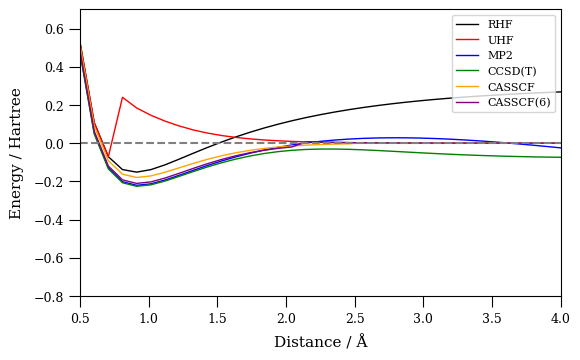

In [56]:
# Plot of the curves relative to the atom energies

# define figure
fig = plt.figure(figsize=(fig_width, fig_height))
spec = fig.add_gridspec(ncols=1, nrows=1, height_ratios=[1])

# define subplots
ax1 = fig.add_subplot(spec[0, 0])

# plot data
ax1.plot(x, RHF-(H_energy[3]+F_energy[3]), label='RHF', linewidth=lw)
ax1.plot(x, UHF-(H_energy[4]+F_energy[4]), label='UHF', linewidth=lw)
ax1.plot(x, MP2-(H_energy[2]+F_energy[2]), label='MP2', linewidth=lw)
ax1.plot(x, CCSD_T-(H_energy[1]+F_energy[1]), label='CCSD(T)', linewidth=lw)
ax1.plot(x, CASSCF-(H_energy[0]+F_energy[0]), label='CASSCF', linewidth=lw)
ax1.plot(x, CASSCF_6-(H_energy[5]+F_energy[5]), label='CASSCF(6)', linewidth=lw)

# Add a dashed line at y = 0
ax1.axhline(0, linestyle='--', color='grey', linewidth=0.5)

# set labels
ax1.set_xlabel('Distance / Å')
ax1.set_ylabel('Energy / Hartree')

# set limits
ax1.set_xlim(0.5, 4.0)
ax1.set_ylim(-0.8, 0.7)

# set legend and title
ax1.legend(loc='upper right', fancybox=True, fontsize=8)

# show plot
plt.show()

# save plot
save_plot_as_pdf(fig, 'Plots/Relative_energies.pdf')
